In [1]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import pickle
import plotly.figure_factory as ff
import plotly.plotly as py
import pandas as pd
import pickle

Using TensorFlow backend.


In [2]:
def generator(IDs, yields, batch_size, cutoff=38, allSample=False):
    import numpy as np
    import random
    
 # Create empty arrays to contain batch of features and labels#

    if allSample == False:
        batch_features = np.zeros((batch_size, cutoff, 1, 128, 11))
        batch_yields = np.zeros((batch_size))
        while True:
            for i in range(batch_size):
                # choose random index in features
                index = random.choice(range(len(IDs)))
                ID = IDs[index]
                if np.sum(np.isnan(np.load('data/PROCESSED_III/' + ID + '.npy'))) == 0:
                    batch_features[i, :, :, :, :] = np.load('data/PROCESSED_III/' + ID + '.npy')[:cutoff, :, :, :]
                    #print('yes', ID)
                    batch_yields[i] = yields[ID]
                else:
                    print('no', ID)
            yield batch_features, batch_yields
            
    if allSample == True:
        batch_features = np.zeros((batch_size, cutoff, 1, 128, 11))
        batch_yields = np.zeros((batch_size))
        for i, ID in enumerate(IDs):
            if np.sum(np.isnan(np.load('data/PROCESSED_III/' + ID + '.npy'))) == 0:
                batch_features[i, :, :, :, :] = np.load('data/PROCESSED_III/' + ID + '.npy')[:cutoff, :, :, :]
                #print('yes', ID)
                batch_yields[i] = yields[ID]
            else:
                print('no', ID)
        yield batch_features, batch_yields

In [3]:
# Load data

yields = pickle.load(open('data/yields.p', 'rb'))
y = yields

model_38 = load_model('CONVLSTM')
IDs = list(yields['validation'].keys())

test_gen = generator(list(yields['validation'].keys()), yields['validation'], len(yields['validation']), allSample=True)
X_test, y_test = next(test_gen)

In [4]:
# Average yields
np.average(list(yields['validation'].values()))

154.82956393200297

In [5]:
# Getting predicted values and error

y_pred = model_38.predict(X_test, batch_size=16, verbose=1)
y_pred = [y[0] for y in y_pred]

y_diff = np.abs(y_test - y_pred)/y_test*100
plot_fips = ['{:02d}'.format(int(ID.split('_')[1])) + \
              '{:03d}'.format(int(ID.split('_')[2])) for ID in IDs]

1353/1353 [==============================] - 35s 26ms/step


In [6]:
# plotting choropleth for ground truth

endpts=[40, 60, 80, 100, 120, 140, 160, 180, 200, 220]

fig = ff.create_choropleth(
    fips=plot_fips, values=y_test,
    binning_endpoints=endpts,
    #colorscale=colorscale,
    show_state_data=True,
    #text = plot_text['Text'], 
    show_hover=True, centroid_marker={'opacity': 0},
    asp=3.1, title='Groun Truth Corn Yields in 2016',
    legend_title='Yields (Bushel/Acre)',
    state_outline={'color':'grey', 'width': 1.0}
)

py.iplot(fig, filename='choropleth_yields_truth')

D:\Programs\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [7]:
# plotting choropleth MAE

endpts=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

fig = ff.create_choropleth(
    fips=plot_fips, values=y_diff,
    binning_endpoints=endpts,
    #colorscale=colorscale,
    show_state_data=True,
    #text = plot_text['Text'], 
    show_hover=True, centroid_marker={'opacity': 0},
    asp=3.1, title='Percent Error of Predicted Corn Yields in 2016',
    legend_title='Percent Error',
    state_outline={'color':'grey', 'width': 1.0}
)

py.iplot(fig, filename='choropleth_38fames')

D:\Programs\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




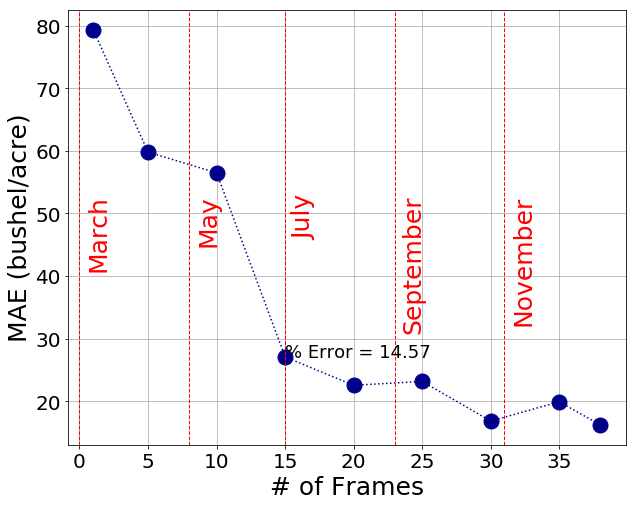

In [8]:
# Plotting MAE versus reduced number of frames per year

import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

error_frames = pickle.load(open('abs_error_frames.p', 'rb'))
error_frames = np.append(error_frames, 16.20)  # Append reported error from using 38 frames (printed in train_and_evaluate notebook)
n_frames = [1, 5, 10, 15, 20, 25, 30, 35, 38]

plt.figure(figsize=(10,8))
plt.plot(n_frames, error_frames, color='darkblue', linestyle=':', marker='o', markersize=15)

plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.text(0.5,  50, 'March', rotation=90, color='red', fontsize=25)

plt.axvline(x=8, color='red', linestyle='--', linewidth=1)
plt.text(8.5,  50, 'May', rotation=90, color='red', fontsize=25)

plt.axvline(x=15, color='red', linestyle='--', linewidth=1)
plt.text(15.5, 50 , 'July', rotation=90, color='red', fontsize=25)

plt.axvline(x=23, color='red', linestyle='--', linewidth=1)
plt.text(23.5,  50 , 'September', rotation=90, color='red', fontsize=25)

plt.axvline(x=31, color='red', linestyle='--', linewidth=1)
plt.text(31.5,  50 , 'November', rotation=90, color='red', fontsize=25)

plt.text(15,  27 , '% Error = {:.2f}'.format(error_frames[4]/154.82956393200297*100), rotation=0, color='Black', fontsize=18)

plt.xlabel('# of Frames', fontsize=25)
plt.ylabel('MAE (bushel/acre)', fontsize=25)
plt.grid()
plt.savefig('MAE_frames', dpi=500)
plt.show()